In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
from timm import create_model
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer

In [6]:
images_path = '../../data/resized_and_user_images'
labels_path = '../../data/resized_and_user_labels.csv'

In [7]:
data = pd.read_csv(labels_path, index_col='filename')

def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(data.loc[filename])[0::2], list(data.loc[filename])[1::2])
    return tensor(list(zipped))

In [17]:
dblock = DataBlock(
    get_items=get_image_files,
    blocks=(ImageBlock, PointBlock),
    splitter=RandomSplitter(valid_pct=0.15),
    get_y=get_y_func,
    batch_tfms=[
        *aug_transforms(
            do_flip=False,
            size=(224,224), 
            max_rotate=15,
            max_lighting=0.5,
            max_warp=0.4
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

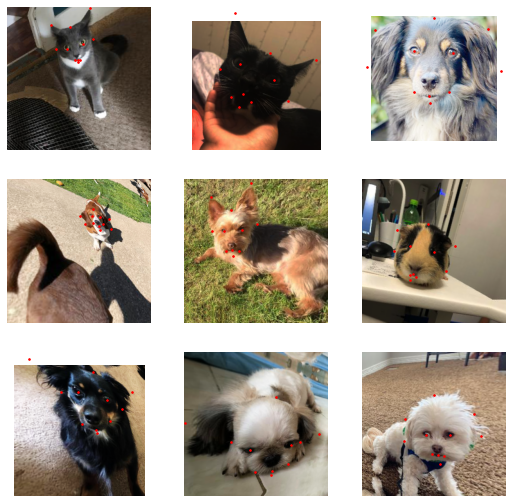

In [18]:
dls = dblock.dataloaders(images_path, bs=64)
dls.c = dls.train.after_item.c
dls.show_batch()

In [19]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, 
                        init=nn.init.kaiming_normal_, custom_head=None, concat_pool=True, **kwargs):
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

def timm_learner(dls, arch:str, loss_func=MSELossFlat(), opt_func=ranger, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [20]:
learn = timm_learner(dls, 'efficientnet_b3a')

In [9]:
learn.lr_find()

In [10]:
learn.fit_flat_cos(
    10, 
    3e-2,
    wd=0.1,
    cbs=[
        SaveModelCallback()
    ]
)

epoch,train_loss,valid_loss,time


In [27]:
!pwd

/Users/henry.dashwood/Documents/facial-features-detector/code/efficientnet


In [31]:
learn.load('efficientnet_b3a_4_1_0_0_3e-2')

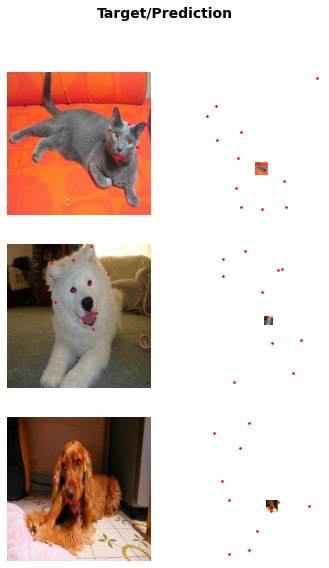

In [9]:
learn.show_results()

In [27]:
learn.unfreeze()

In [28]:
frozen_params = filter(lambda p: not p.requires_grad, learn.model.parameters())
frozen_params = sum([np.prod(p.size()) for p in frozen_params])
unfrozen_params = filter(lambda p: p.requires_grad, learn.model.parameters())
unfrozen_params = sum([np.prod(p.size()) for p in unfrozen_params])
frozen_params, unfrozen_params

(0, 12287528)

In [29]:
learn.lr_find()

In [10]:
learn.predict()

In [11]:
%%writefile bentoml_service.py
from bentoml import BentoService, api, artifacts, env
from bentoml.frameworks.fastai2 import Fastai2ModelArtifact
from bentoml.adapters import ImageInput

@env(pip_dependencies=['fastai'])
@artifacts([Fastai2ModelArtifact('learner')])
class PetRegression(BentoService):
    
    @api(input=ImageInput(), batch=True)
    def predict(self, image):
        preds = self.artifacts.regressor.predict(image)
        return preds

Overwriting bentoml_service.py


In [12]:
import bentoml

from fastcore.utils import remove_patches_path
from bentoml_service import PetRegression

svc = PetRegression()
svc.pack('learner', learn)

# Fastcore modify Pathlib module from python, need to remove the patch in order to save
with remove_patches_path():
    saved_path = svc.save()

[2020-09-24 12:19:20,844] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-24 12:19:21,070] WARNING - BentoML by default does not include spacy and torchvision package when using Fastai2ModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2020-09-24 12:19:21,073] WARNING - pip package requirement `fastai2>=2.0.0` not found in current python environment
[2020-09-24 12:19:23,956] INFO - Detected non-PyPI-released BentoML installed, copying local BentoML modulefiles to target saved bundle path..
no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching '

In [13]:
bento_tag = f'{svc.name}:{svc.version}'

In [14]:
!bentoml serve PetRegression:latest

[2020-09-24 12:20:54,391] INFO - Getting latest version PetRegression:20200924121922_C9F37D
[2020-09-24 12:20:54,392] INFO - Starting BentoML API server in development mode..
[2020-09-24 12:20:56,148] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-24 12:20:56,170] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+10.gfcfe0f5
Traceback (most recent call last):
  File "/Users/henry.dashwood/.pyenv/versions/3.8.5/envs/py385/bin/bentoml", line 33, in <module>
    sys.exit(load_entry_point('BentoML', 'console_scripts', 'bentoml')())
  File "/Users/henry.dashwood/.vscode/extensions/ms-python.python-2020.9.111407/pythonFiles/lib/python/click/core.py", line 829, in __call__
    return self